In [1]:
# Cell 1: Imports and Setup
import networkx as nx
import matplotlib.pyplot as plt
from topolansatz.topology import TopologyHandler
from topolansatz.circuits import CircuitBuilder
from topolansatz.evaluator import CircuitEvaluator
from topolansatz.stitching import CircuitStitcher
from topolansatz.main import TopolAnsatz
import time
import numpy as np

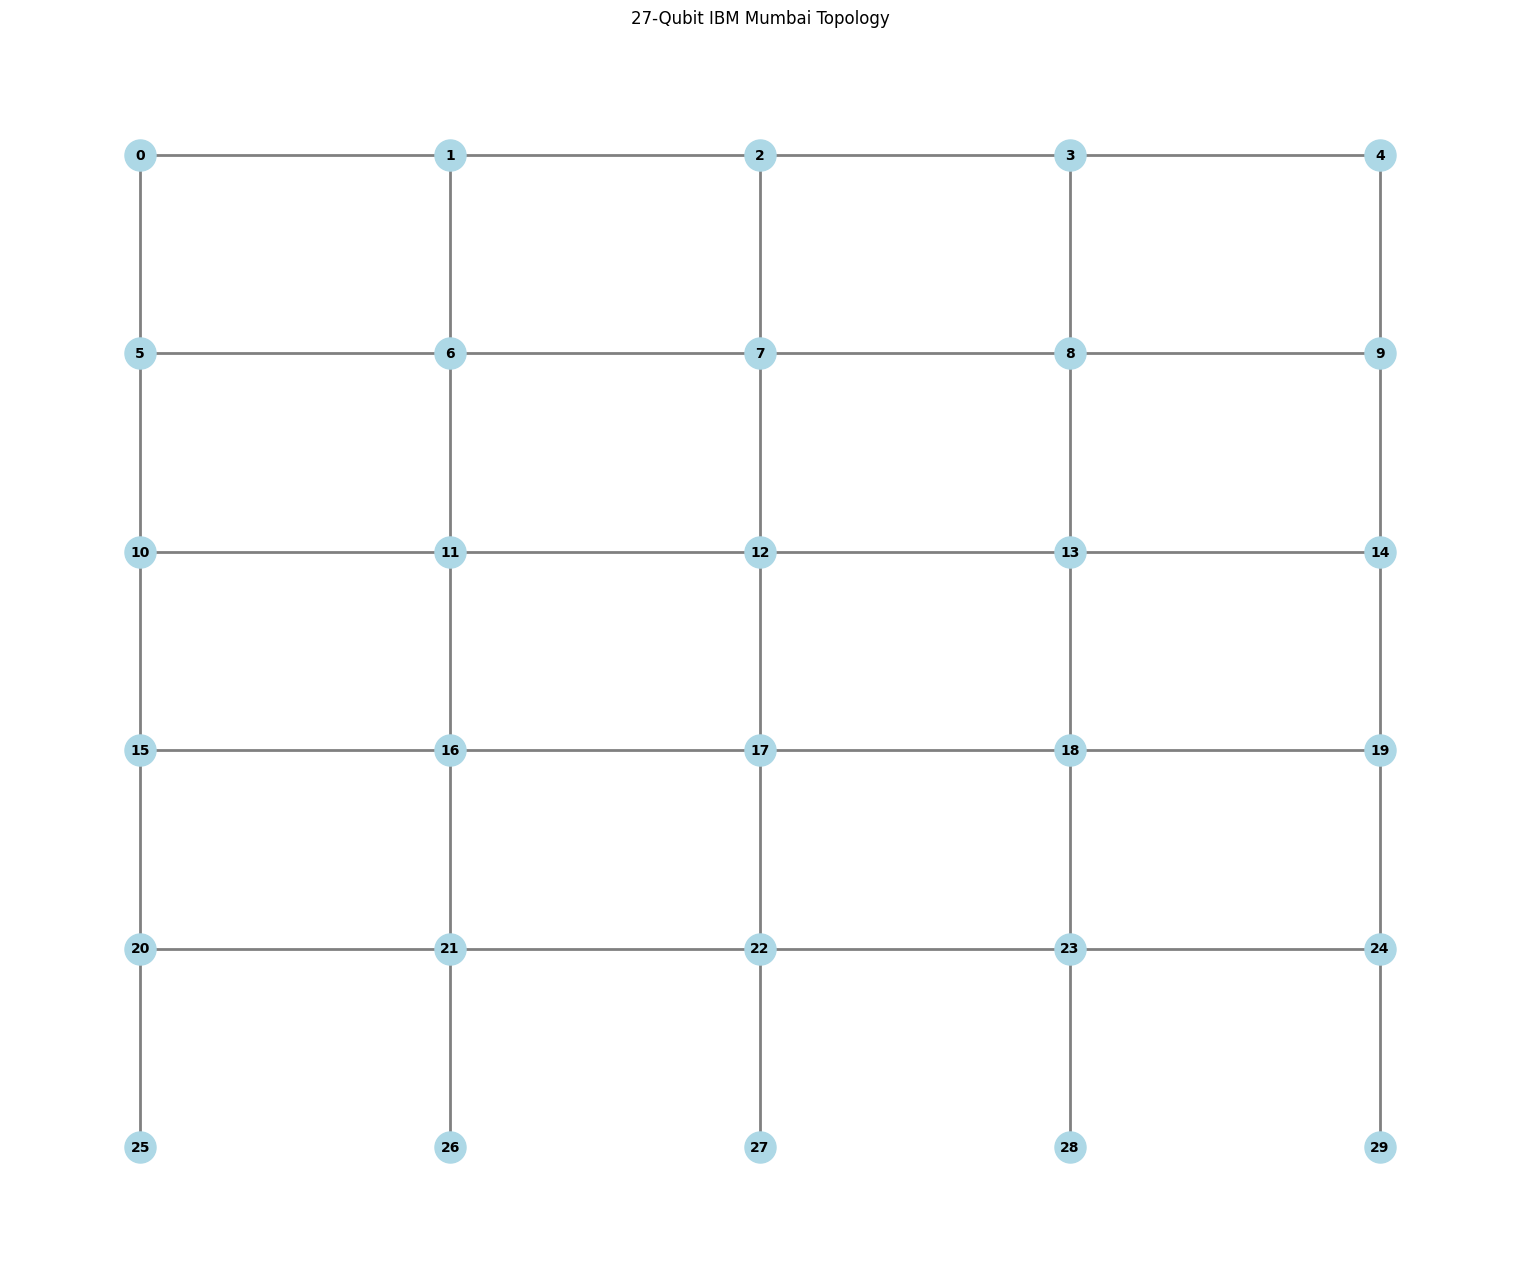

Topology Analysis:
----------------------------------------
Number of qubits: 30
Number of connections: 45
Average degree: 3.00


In [2]:
# Cell 2: Create 27-qubit IBM Mumbai Topology
def get_ibm_mumbai_coupling():
    """Returns the coupling map for IBM Mumbai (27 qubit)"""
    return [
        (0,1), (1,2), (2,3), (3,4), # Row 0 
        (0,5), (1,6), (2,7), (3,8), (4,9), # Vertical to Row 1
        (5,6), (6,7), (7,8), (8,9), # Row 1
        (5,10), (6,11), (7,12), (8,13), (9,14), # Vertical to Row 2
        (10,11), (11,12), (12,13), (13,14), # Row 2
        (10,15), (11,16), (12,17), (13,18), (14,19), # Vertical to Row 3
        (15,16), (16,17), (17,18), (18,19), # Row 3
        (15,20), (16,21), (17,22), (18,23), (19,24), # Vertical to Row 4
        (20,21), (21,22), (22,23), (23,24), # Row 4
        (20,25), (21,26), (22,27), (23,28), (24,29) # Vertical to Row 5
    ]

# Create and visualize topology
coupling_map = get_ibm_mumbai_coupling()
G = nx.Graph(coupling_map)

# Create a grid-like layout for better visualization
pos = {}
for i in range(6):  # 6 rows
    for j in range(5):  # 5 columns
        node = i*5 + j
        if node < G.number_of_nodes():
            pos[node] = np.array([j, -i])

plt.figure(figsize=(15, 12))
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=500, width=2, edge_color='gray',
        font_size=10, font_weight='bold')
plt.title("27-Qubit IBM Mumbai Topology", pad=20)
plt.show()

print("Topology Analysis:")
print("-" * 40)
print(f"Number of qubits: {G.number_of_nodes()}")
print(f"Number of connections: {G.number_of_edges()}")
print(f"Average degree: {2*G.number_of_edges()/G.number_of_nodes():.2f}")

Analyzing Partitioning Strategies:
----------------------------------------

Trying 6-6-6-5-4 split
Partition sizes: [6, 6, 6, 5, 4]
✓ Found 6-qubit subgraph: [0, 1, 2, 3, 4, 5]
✓ Found 6-qubit subgraph: [6, 7, 8, 9, 10, 11]
✓ Found 6-qubit subgraph: [12, 13, 14, 15, 16, 17]
✓ Found 5-qubit subgraph: [18, 19, 21, 22, 23]
✗ Could not find valid 4-qubit subgraph

Trying 6-6-5-5-5 split
Partition sizes: [6, 6, 5, 5, 5]
✓ Found 6-qubit subgraph: [0, 1, 2, 3, 4, 5]
✓ Found 6-qubit subgraph: [6, 7, 8, 9, 10, 11]
✓ Found 5-qubit subgraph: [12, 13, 14, 16, 17]
✓ Found 5-qubit subgraph: [15, 20, 21, 22, 23]
✗ Could not find valid 5-qubit subgraph

Trying 5-5-5-4-4-4 split
Partition sizes: [5, 5, 5, 4, 4, 4]
✓ Found 5-qubit subgraph: [0, 1, 2, 3, 4]
✓ Found 5-qubit subgraph: [5, 6, 7, 8, 9]
✓ Found 5-qubit subgraph: [10, 11, 12, 13, 14]
✓ Found 4-qubit subgraph: [15, 16, 17, 18]
✓ Found 4-qubit subgraph: [19, 22, 23, 24]
✓ Found 4-qubit subgraph: [20, 21, 25, 26]
✓ Valid partition strategy found

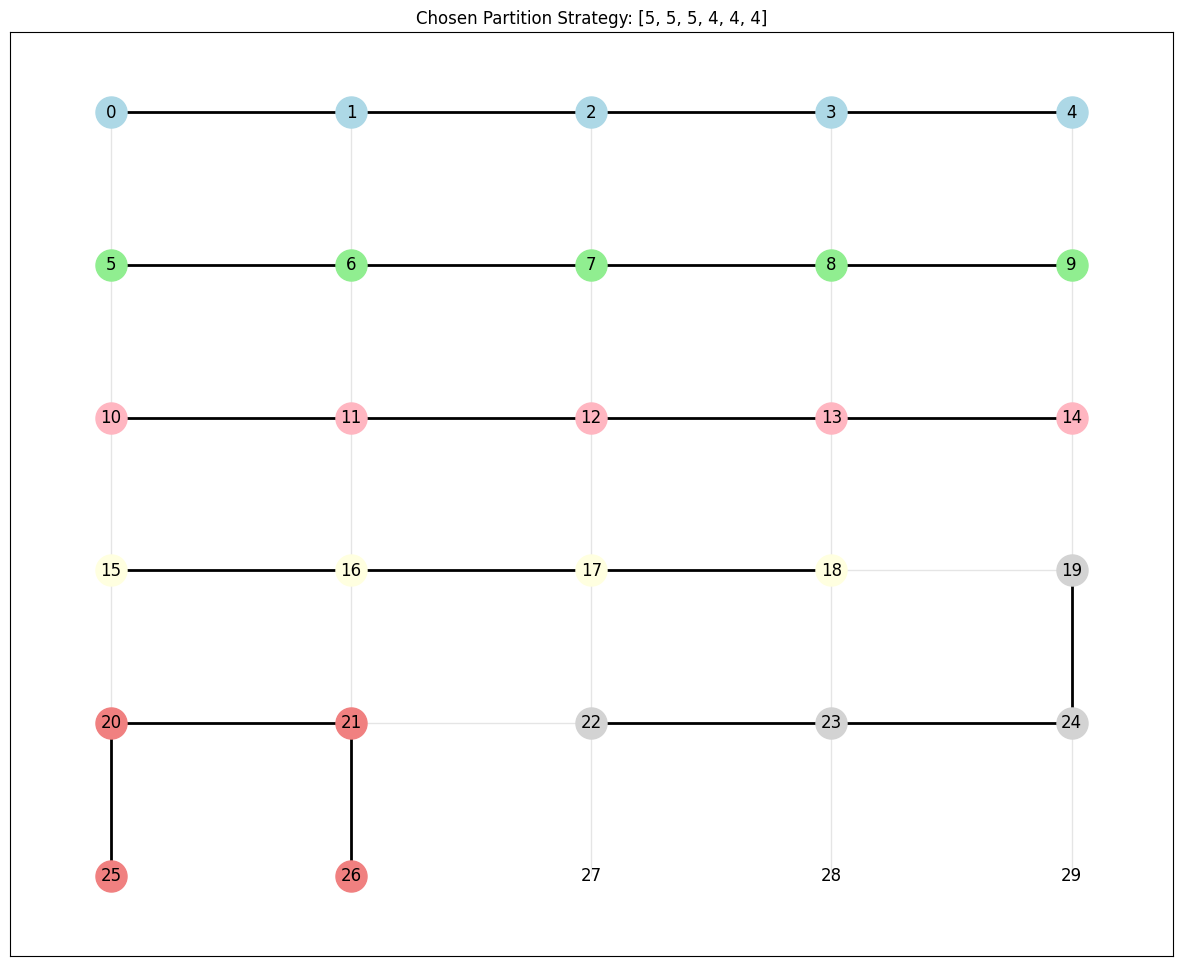

In [3]:
# Cell 3: Analyze Possible Partitioning Strategies
topology = TopologyHandler(coupling_map)

# Define possible partitioning strategies
strategies = [
    ([6,6,6,5,4], "6-6-6-5-4 split"),
    ([6,6,5,5,5], "6-6-5-5-5 split"),
    ([5,5,5,4,4,4], "5-5-5-4-4-4 split"),
    ([4,4,4,4,4,4,3], "4-4-4-4-4-4-3 split")
]

print("Analyzing Partitioning Strategies:")
print("-" * 40)

best_strategy = None
best_subgraphs = None

for partition_sizes, name in strategies:
    print(f"\nTrying {name}")
    print(f"Partition sizes: {partition_sizes}")
    
    if sum(partition_sizes) != 27:
        print(f"✗ Invalid partition sum: {sum(partition_sizes)}")
        continue
        
    subgraphs = []
    used_qubits = set()
    success = True
    
    for size in partition_sizes:
        possible = topology.get_connected_subgraphs(size)
        valid_subgraphs = []
        
        for sg in possible:
            sg_qubits = set(sg.nodes())
            if not sg_qubits.intersection(used_qubits):
                valid_subgraphs.append(sg)
        
        if not valid_subgraphs:
            print(f"✗ Could not find valid {size}-qubit subgraph")
            success = False
            break
            
        chosen_sg = valid_subgraphs[0]
        subgraphs.append(chosen_sg)
        used_qubits.update(chosen_sg.nodes())
        print(f"✓ Found {size}-qubit subgraph: {sorted(chosen_sg.nodes())}")
    
    if success:
        print(f"✓ Valid partition strategy found!")
        best_strategy = partition_sizes
        best_subgraphs = subgraphs
        break

if best_strategy is None:
    raise ValueError("No valid partitioning strategy found")

# Visualize chosen subgraphs with different colors
plt.figure(figsize=(15, 12))
colors = ['lightblue', 'lightgreen', 'lightpink', 'lightyellow', 
          'lightgray', 'lightcoral', 'lightskyblue']

# Draw base topology in light gray
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray')

# Draw each subgraph with different color
for i, sg in enumerate(best_subgraphs):
    nx.draw_networkx_nodes(G, pos, nodelist=list(sg.nodes()), 
                          node_color=colors[i], node_size=500)
    nx.draw_networkx_edges(G, pos, edgelist=list(sg.edges()), 
                          edge_color='black', width=2)

nx.draw_networkx_labels(G, pos)
plt.title(f"Chosen Partition Strategy: {best_strategy}")
plt.show()

In [4]:
# Cell 4: Generate SubCircuits
print("Generating SubCircuits")
print("-" * 40)

subcircuits = []
subgraph_mappings = []
depth = 2  # Circuit depth per subcircuit

for i, subgraph in enumerate(best_subgraphs):
    print(f"\nGenerating circuit for subgraph {i+1} ({len(subgraph)} qubits):")
    
    # Normalize subgraph indices
    norm_graph, mapping = topology.normalize_indices(subgraph)
    print(f"Qubit mapping: {mapping}")
    
    # Create circuit
    builder = CircuitBuilder(norm_graph, f"sub_{i}")
    circuit = builder.create_circuit(depth)
    
    print(f"Circuit statistics:")
    print(f"- Qubits: {circuit.num_qubits}")
    print(f"- Depth: {circuit.depth()}")
    print(f"- Parameters: {len(circuit.parameters)}")
    
    # Analyze gates
    gate_counts = {}
    for inst in circuit.data:
        gate_name = inst.operation.name
        gate_counts[gate_name] = gate_counts.get(gate_name, 0) + 1
    print(f"- Gates: {gate_counts}")
    
    subcircuits.append(circuit)
    subgraph_mappings.append(mapping)
    
print(f"\nTotal subcircuits generated: {len(subcircuits)}")

Generating SubCircuits
----------------------------------------

Generating circuit for subgraph 1 (5 qubits):
Qubit mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
Circuit statistics:
- Qubits: 5
- Depth: 8
- Parameters: 6
- Gates: {'rz': 3, 't': 1, 'rx': 3, 'h': 1, 'cx': 5, 'swap': 3, 's': 1, 'x': 1}

Generating circuit for subgraph 2 (5 qubits):
Qubit mapping: {0: 5, 1: 6, 2: 7, 3: 8, 4: 9}
Circuit statistics:
- Qubits: 5
- Depth: 8
- Parameters: 5
- Gates: {'ry': 3, 'x': 3, 'rz': 2, 'cx': 5, 'swap': 3, 's': 1, 't': 1}

Generating circuit for subgraph 3 (5 qubits):
Qubit mapping: {0: 10, 1: 11, 2: 12, 3: 13, 4: 14}
Circuit statistics:
- Qubits: 5
- Depth: 8
- Parameters: 5
- Gates: {'s': 2, 'x': 1, 'h': 2, 'rz': 4, 'cx': 4, 'swap': 4, 'rx': 1}

Generating circuit for subgraph 4 (4 qubits):
Qubit mapping: {0: 16, 1: 17, 2: 18, 3: 15}
Circuit statistics:
- Qubits: 4
- Depth: 7
- Parameters: 5
- Gates: {'s': 1, 'ry': 2, 'h': 1, 'rz': 1, 'swap': 1, 'cx': 5, 'rx': 2, 'x': 1}

Generating circuit 

Analyzing Stitching Points
----------------------------------------

Connections between subcircuit 0 and 1:
- Qubit 0 ↔ Qubit 5
- Qubit 1 ↔ Qubit 6
- Qubit 2 ↔ Qubit 7
- Qubit 3 ↔ Qubit 8
- Qubit 4 ↔ Qubit 9

Connections between subcircuit 1 and 2:
- Qubit 5 ↔ Qubit 10
- Qubit 6 ↔ Qubit 11
- Qubit 7 ↔ Qubit 12
- Qubit 8 ↔ Qubit 13
- Qubit 9 ↔ Qubit 14

Connections between subcircuit 2 and 3:
- Qubit 10 ↔ Qubit 15
- Qubit 11 ↔ Qubit 16
- Qubit 12 ↔ Qubit 17
- Qubit 13 ↔ Qubit 18

Connections between subcircuit 2 and 4:
- Qubit 14 ↔ Qubit 19

Connections between subcircuit 3 and 4:
- Qubit 17 ↔ Qubit 22
- Qubit 18 ↔ Qubit 19
- Qubit 18 ↔ Qubit 23

Connections between subcircuit 3 and 5:
- Qubit 16 ↔ Qubit 21
- Qubit 15 ↔ Qubit 20

Connections between subcircuit 4 and 5:
- Qubit 22 ↔ Qubit 21


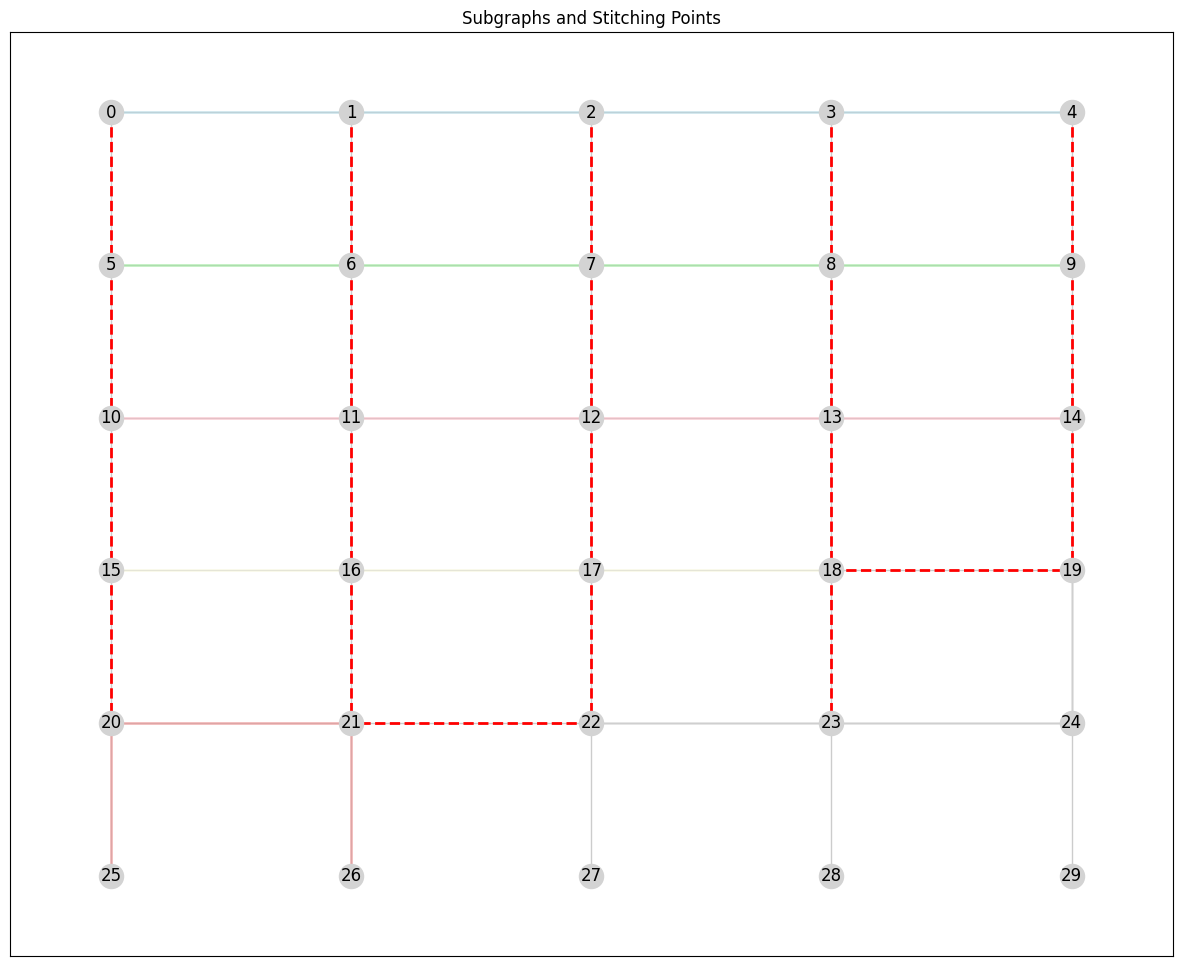

In [5]:
# Cell 5: Analyze Stitching Points
stitcher = CircuitStitcher(CircuitEvaluator(), G)
print("Analyzing Stitching Points")
print("-" * 40)

# Find connections between all pairs of subcircuits
all_connections = []
for i in range(len(subgraph_mappings)-1):
    for j in range(i+1, len(subgraph_mappings)):
        connections = stitcher.find_connection_points(
            [subgraph_mappings[i], subgraph_mappings[j]]
        )
        if connections:
            print(f"\nConnections between subcircuit {i} and {j}:")
            for q1, q2 in connections:
                print(f"- Qubit {q1} ↔ Qubit {q2}")
            all_connections.extend(connections)

# Visualize stitching points
plt.figure(figsize=(15, 12))
# Draw base topology
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_nodes(G, pos, node_color='lightgray')
nx.draw_networkx_labels(G, pos)

# Draw subgraph boundaries
for i, sg in enumerate(best_subgraphs):
    nx.draw_networkx_edges(G, pos, edgelist=list(sg.edges()),
                          edge_color=colors[i], width=2, alpha=0.5)

# Draw connection points in red
conn_graph = nx.Graph()
conn_graph.add_edges_from(all_connections)
nx.draw_networkx_edges(conn_graph, pos, edge_color='red',
                      width=2, style='dashed')
plt.title("Subgraphs and Stitching Points")
plt.show()

In [6]:
# Cell 6: Generate Final Ansatz
print("Generating Final Ansatz")
print("-" * 40)

# Initialize TopolAnsatz
topol = TopolAnsatz(coupling_map)

# Generate ansatz with specific partitioning
start_time = time.time()
ansatz = topol.generate_partitioned_ansatz(
    partition_sizes=best_strategy,
    depth=depth
)
gen_time = time.time() - start_time

print(f"Generation time: {gen_time:.2f} seconds")
print(f"\nFinal Ansatz Properties:")
print(f"- Number of qubits: {ansatz.num_qubits}")
print(f"- Circuit depth: {ansatz.depth()}")
print(f"- Number of parameters: {len(ansatz.parameters)}")

# Analyze gate composition
gate_counts = {}
for inst in ansatz.data:
    gate_name = inst.operation.name
    gate_counts[gate_name] = gate_counts.get(gate_name, 0) + 1

print("\nGate composition:")
for gate, count in gate_counts.items():
    print(f"- {gate}: {count}")

# Evaluate quality metrics
# metrics = topol.evaluate_ansatz(ansatz)
# print("\nCircuit quality metrics:")
# for metric, value in metrics.items():
#     print(f"- {metric}: {value:.4f}")

# Draw final circuit structure
print("\nFinal Circuit:")
print(ansatz.draw())

Generating Final Ansatz
----------------------------------------
Generation time: 2.92 seconds

Final Ansatz Properties:
- Number of qubits: 27
- Circuit depth: 4
- Number of parameters: 26

Gate composition:
- circuit-168: 1
- circuit-169: 1
- circuit-170: 1
- circuit-171: 1
- circuit-172: 1
- circuit-173: 1
- cx: 9

Final Circuit:
      »
 q_0: »
      »
 q_1: »
      »
 q_2: »
      »
 q_3: »
      »
 q_4: »
      »
 q_5: »
      »
 q_6: »
      »
 q_7: »
      »
 q_8: »
      »
 q_9: »
      »
q_10: »
      »
q_11: »
      »
q_12: »
      »
q_13: »
      »
q_14: »
      »
q_15: »
      »
q_16: »
      »
q_17: »
      »
q_18: »
      »
q_19: »
      »
q_20: »
      »
q_21: »
      »
q_22: »
      »
q_23: »
      »
q_24: »
      »
q_25: »
      »
q_26: »
      »
«            ┌─────────────────────────────────────────────────────────────────────────────────────────────┐       »
« q_0: ──────┤0                                                                                            ├